In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlrose_hiive as mlrose

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import preprocessing

import torch
from torch import nn, optim
from torch.nn import functional as F

import numpy as np

np.random.seed(1234)
from collections import Counter
import time

# A. Preprocess the Dataset 
### (same code used as in Assignment 1 to ensure consistency)

In [2]:
df = pd.read_csv("dataset/adult_income.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


### 1. Assigning proper dataype to columns

In [3]:
df.age = df.age.astype(float)
df['hours-per-week'] = df['hours-per-week'].astype(float)

### 2. Clubbing similar categories together, for a given feature column

In [4]:
df['education'].replace('Preschool', 'dropout',inplace=True)
df['education'].replace('10th', 'dropout',inplace=True)
df['education'].replace('11th', 'dropout',inplace=True)
df['education'].replace('12th', 'dropout',inplace=True)
df['education'].replace('1st-4th', 'dropout',inplace=True)
df['education'].replace('5th-6th', 'dropout',inplace=True)
df['education'].replace('7th-8th', 'dropout',inplace=True)
df['education'].replace('9th', 'dropout',inplace=True)
df['education'].replace('HS-Grad', 'HighGrad',inplace=True)
df['education'].replace('HS-grad', 'HighGrad',inplace=True)
df['education'].replace('Some-college', 'CommunityCollege',inplace=True)
df['education'].replace('Assoc-acdm', 'CommunityCollege',inplace=True)
df['education'].replace('Assoc-voc', 'CommunityCollege',inplace=True)
df['education'].replace('Bachelors', 'Bachelors',inplace=True)
df['education'].replace('Masters', 'Masters',inplace=True)
df['education'].replace('Prof-school', 'Masters',inplace=True)
df['education'].replace('Doctorate', 'Doctorate',inplace=True)

In [5]:
df['marital-status'].replace('Never-married', 'NotMarried',inplace=True)
df['marital-status'].replace(['Married-AF-spouse'], 'Married',inplace=True)
df['marital-status'].replace(['Married-civ-spouse'], 'Married',inplace=True)
df['marital-status'].replace(['Married-spouse-absent'], 'NotMarried',inplace=True)
df['marital-status'].replace(['Separated'], 'Separated',inplace=True)
df['marital-status'].replace(['Divorced'], 'Separated',inplace=True)
df['marital-status'].replace(['Widowed'], 'Widowed',inplace=True)

### 3. Binning Age, Hours per week  columns

In [6]:
df['age_bin'] = pd.cut(df['age'], 20)

In [7]:
df['hours-per-week_bin'] = pd.cut(df['hours-per-week'], 10)
df['hours-per-week'] = df['hours-per-week']

In [8]:
df['age-hours'] = df['age']*df['hours-per-week']
df['age-hours_bin'] = pd.cut(df['age-hours'], 10)

### 4. Label Encode Categorical columns

In [9]:
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

['education',
 'relationship',
 'occupation',
 'hours-per-week_bin',
 'age-hours_bin',
 'gender',
 'workclass',
 'age_bin',
 'income',
 'marital-status',
 'native-country',
 'race']

In [10]:
for each_col in cat_cols:
    df[each_col] = df[each_col].astype('category').cat.codes

In [11]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,age_bin,hours-per-week_bin,age-hours,age-hours_bin
0,25.0,4,226802,5,7,1,7,3,2,1,0,0,40.0,39,0,2,3,1000.0,1
1,38.0,4,89814,3,9,0,5,0,4,1,0,0,50.0,39,0,5,4,1900.0,2
2,28.0,2,336951,1,12,0,11,0,4,1,0,0,40.0,39,1,3,3,1120.0,1
3,44.0,4,160323,1,10,0,7,0,2,1,7688,0,40.0,39,1,7,3,1760.0,1
4,18.0,0,103497,1,10,1,0,3,4,0,0,0,30.0,39,0,0,2,540.0,0


### 5. Drop reated columns

In [12]:
drop_cols = ['education', 'native-country', 'age-hours_bin','hours-per-week_bin']
df = df.drop(drop_cols, axis=1)

### 6. Make Dataset

In [13]:
y = df["income"].values
X = df.drop(["income"], axis=1).values

### 7. Train-Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101, stratify=y)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39073, 14), (9769, 14), (39073,), (9769,))

In [16]:
Counter(y_train), Counter(y_test)

(Counter({0: 29724, 1: 9349}), Counter({0: 7431, 1: 2338}))

### 8. Normalize dataset

In [17]:
normalizer = preprocessing.Normalizer()
norm_train_X = normalizer.fit_transform(X_train)
norm_test_X  = normalizer.transform(X_test)

In [18]:
norm_train_X.shape

(39073, 14)

### 9. Upsample dataset

In [19]:
#from imblearn.over_sampling import SMOTE
#oversample = SMOTE()
#norm_train_X, y_train = oversample.fit_resample(norm_train_X, y_train)

# B. Modelling comparison amongst multiple Optimizers

In [20]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

In [21]:
HIDDEN_NODES = [8, 8]
SEED = 1234

In [22]:
algorithms = ["gradient_descent", "random_hill_climb", "simulated_annealing", "genetic_alg"]

In [23]:
def run_model_and_collect_results(algorithm, j, data):
    (X_train, y_train, X_test, y_test) = data
    result = []
    model = mlrose.NeuralNetwork(hidden_nodes=HIDDEN_NODES, activation='relu',
                                algorithm=algorithm, max_iters=j, bias=True,
                                is_classifier=True, learning_rate=0.01,
                                early_stopping=True, clip_max=5, max_attempts=100,
                                random_state=SEED)
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_acc = accuracy_score(y_train, y_train_pred)
    y_train_f1 = metrics.f1_score(y_train, y_train_pred)

    y_test_acc = accuracy_score(y_test, y_test_pred)
    y_test_f1 = metrics.f1_score(y_test, y_test_pred)

    result.append([j, algorithm, y_train_acc, y_test_acc, y_train_f1, y_test_f1, end_time-start_time])
    print (result)
    return result

In [24]:
all_results = []
for each_algo in algorithms:
    for i in range(0, 1000, 100):
        result = run_model_and_collect_results(each_algo, i, (norm_train_X, y_train, norm_test_X, y_test))
        all_results.append(result)
        

[[0, 'gradient_descent', 0.7625982136001843, 0.7624117105128467, 0.015704584040747028, 0.014437367303609342, 0.018000125885009766]]
[[100, 'gradient_descent', 0.7625982136001843, 0.7624117105128467, 0.015704584040747028, 0.014437367303609342, 4.586767196655273]]
[[200, 'gradient_descent', 0.7625982136001843, 0.7624117105128467, 0.015704584040747028, 0.014437367303609342, 4.879742622375488]]
[[300, 'gradient_descent', 0.7625982136001843, 0.7624117105128467, 0.015704584040747028, 0.014437367303609342, 4.808510780334473]]
[[400, 'gradient_descent', 0.7625982136001843, 0.7624117105128467, 0.015704584040747028, 0.014437367303609342, 4.580819606781006]]
[[500, 'gradient_descent', 0.7625982136001843, 0.7624117105128467, 0.015704584040747028, 0.014437367303609342, 4.559543609619141]]
[[600, 'gradient_descent', 0.7625982136001843, 0.7624117105128467, 0.015704584040747028, 0.014437367303609342, 4.517324924468994]]
[[700, 'gradient_descent', 0.7625982136001843, 0.7624117105128467, 0.0157045840407

In [37]:
#df = pd.DataFrame(all_results, columns=["Iterations", "Algorithm", "Train Accuracy", "Test Accuracy", "Train F1 Score", "Test F1 Score", "Clock Time"])
#df.to_excel("Backprop_results.xlsx", index=False)

In [32]:
df = pd.DataFrame(columns=["Iterations", "Algorithm", "Train Accuracy", "Test Accuracy", "Train F1 Score", "Test F1 Score", "Clock Time"])
for each in all_results:
    df_sub = pd.DataFrame(each, columns=["Iterations", "Algorithm", "Train Accuracy", "Test Accuracy", "Train F1 Score", "Test F1 Score", "Clock Time"])
    df = pd.concat([df, df_sub])

In [36]:
df.to_excel("Backprop_results.xlsx", index=False)

In [39]:
def plot_feature(feature):
    for each_algo in algorithms:
        x = df[df.Algorithm == each_algo]["Iterations"]
        y = df[df.Algorithm == each_algo][feature]
    
        plt.plot(x,y, label = f"{each_algo}")
    title = f"{feature} comparison"
    plt.title(title)
    plt.ylabel(feature)
    plt.xlabel("Iterations")
    plt.legend()
    plt.grid()
    #plt.savefig(f"{title}.png")

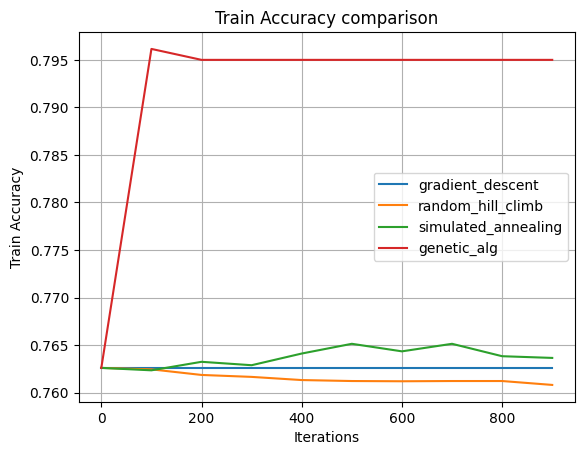

In [41]:
plot_feature("Train Accuracy")

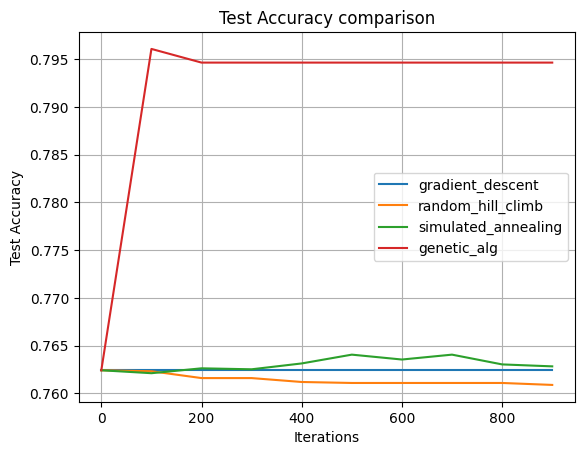

In [42]:
plot_feature("Test Accuracy")

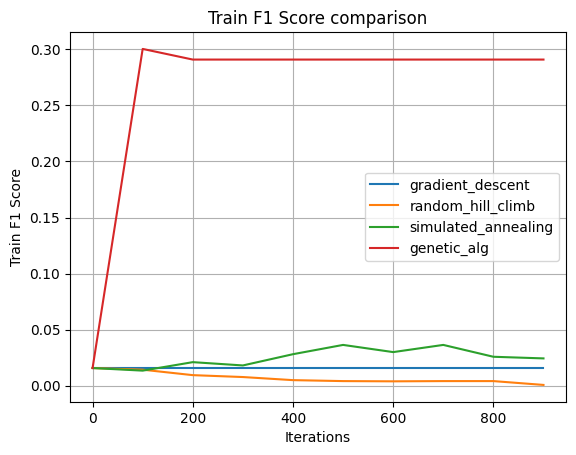

In [43]:
plot_feature("Train F1 Score")

In [119]:
# Experiment Setup

TITLE = "NN_FINETUNING_GA"
iterations = 100
attempts = [10, 50, 100]
pop_size = [100, 200, 300]
mutation_prob = [0.1, 0.4, 0.7]


attempt_default = 10
pop_size_default = 250
mutation_prob_default=0.4

nn_model = mlrose.NeuralNetwork(hidden_nodes=HIDDEN_NODES, activation='relu',
                                bias=True, is_classifier=True, learning_rate = 0.001,
                               early_stopping = True, random_state=SEED, 
                               algorithm="genetic_alg", max_iters=iterations,
                               max_attempts = attempt_default, pop_size=pop_size_default,
                               mutation_prob=mutation_prob_default)
nn_model.fit(X_train, y_train)

TypeError: 'list' object is not callable

In [121]:
nn_model.fitness_curve

[]

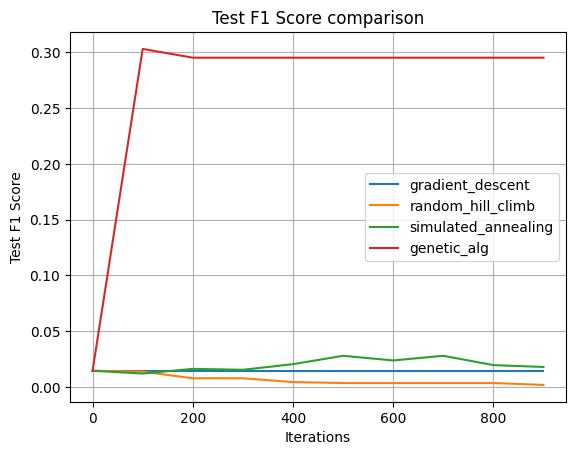

In [44]:
plot_feature("Test F1 Score")